In [2]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.integrate as integrate
from matplotlib.pyplot import figtext


In [3]:
%matplotlib inline

# styling matplotlib
plt.style.use('fivethirtyeight')

In [4]:
from functools import wraps


def auto_save(dpi: int = 600):
    def decorator(fn):
        @wraps(fn)
        def wrapper(*args, **kwargs):
            figure = fn(*args, **kwargs)
            figure.savefig(f'figures/{fn.__name__}', bbox_inches='tight', dpi=dpi)
            return figure

        return wrapper

    return decorator

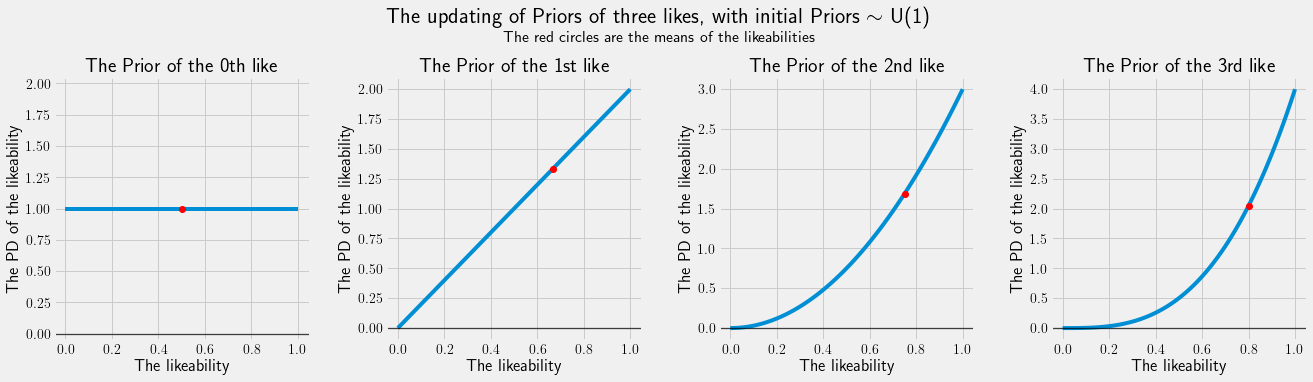

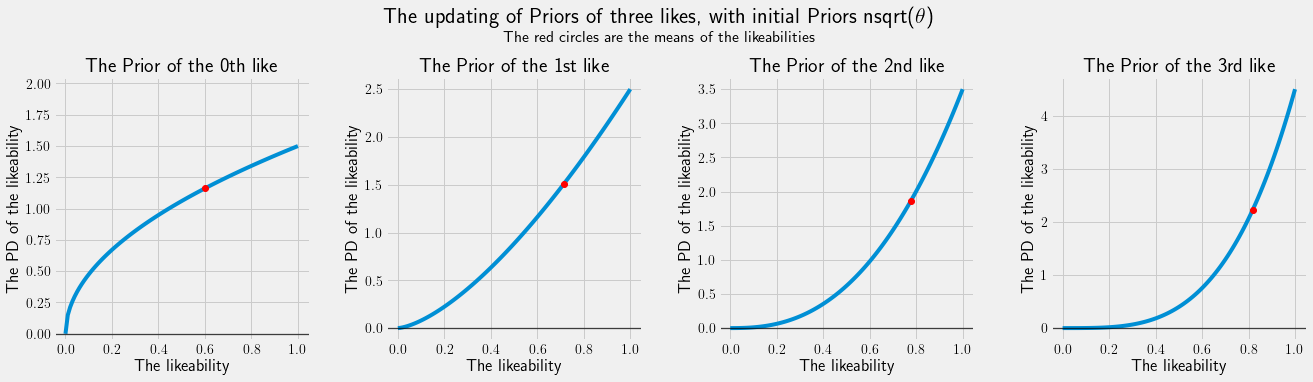

In [32]:
from scipy.stats import beta
import math
"""
Graphics for the bayesian example
"""

# allow LaTeX
plt.rcParams['text.usetex'] = True


def ordinaltg(n):
    return str(n) + {1: 'st', 2: 'nd', 3: 'rd'}.get(4 if 10 <= n % 100 < 20 else n % 10, "th")


def calc_prob(rolls: str):
    likes = 0
    dislikes = 0

    prob = [0.5]
    for c in rolls:
        if c == 'L':
            likes += 1
        else:
            dislikes += 1
        prob.append((likes + 1) / (likes + dislikes + 2))
    return prob


# for a series of LLDLLLDL
# the likes/dislikes scenario, fig 2
@auto_save()
def incremental_beliefs():
    fig = plt.figure(figsize=(12, 6))
    ax = fig.add_subplot(111)

    rolls = "LLDLLLD"
    xs = ["base", *[str(c) + str(i + 1) for i, c in enumerate(rolls)]]
    ys = calc_prob(rolls)

    ax.plot(xs, ys)
    ax.set_ylim(0, 1)
    ax.set_xlabel(r'The new rating on top of previous ratings')
    ax.set_ylabel('The best estimate of likeability of the video')
    figtext(0.5, 0.9, 'The likeability of a video given successive likes and dislikes', fontsize=18, ha='center')
    figtext(0.5, 0.85, 'L2 = the second rating being a like; D3 = the third rating being a dislike', fontsize=12,
            ha='center')

    return fig


def integ(fn, a, b, dx=0.01):
    t = 0
    x = a
    while x <= b:
        t += fn(x) * dx
        x += dx

    return t

# for a series of LLD
# shows the updates of P(theta)
@auto_save()
def updating_priors():
    rolls = "LLL"
    ngraphs = len(rolls) + 1

    width = ngraphs
    height = 1
    fig, axs = plt.subplots(height, width, figsize=(5 * width, 5 * height))
    plt.subplots_adjust(wspace=0.3, hspace=0.3, top=0.80)
    figtext(0.5, 0.95, 'The updating of Priors of three likes, with initial Priors $\sim$ U(1)', fontsize=22,
            ha='center')
    figtext(0.5, 0.9, 'The red circles are the means of the likeabilities', fontsize=16,
            ha='center')
    xs = np.arange(0, 1.01, 0.01)

    priors = [0] * ngraphs
    priors[0] = lambda theta: 1
    likelihoods = [0] * ngraphs
    evidences = [0] * ngraphs

    # first prior
    ys = [priors[0](x) for x in xs]
    ax = axs[0]
    ax.plot(xs, ys)
    ax.set_title(f"The Prior of the {ordinaltg(0)} like")
    ax.set_ylabel("The PD of the likeability")
    ax.set_xlabel("The likeability")
    ax.plot(0.5, 1, 'ro')
    ax.set_ylim(-0.05, 2.05)
    ax.axhline(y=0, color='black', linewidth=1.3, alpha=0.7)

    index = 0
    while index < len(rolls):
        roll = rolls[index]
        is_like = roll == 'L'

        if is_like:
            likelihoods[index] =  lambda t1: t1
        else:
            likelihoods[index] = lambda t1: 1 - t1

        evidences[index] = integrate.quad(lambda t, i=index: likelihoods[i](t) * priors[i](t), 0, 1)[0]
        priors[index + 1] = lambda t, i=index: likelihoods[i](t) * priors[i](t) / evidences[i]

        mean = integrate.quad(lambda t, i=index: t * priors[i + 1](t), 0, 1)
        ys = [priors[index + 1](x) for x in xs]
        ax = axs[index + 1]

        ax.plot(xs, ys)
        # plot mean
        ax.plot([mean[0]], [priors[index + 1](mean[0])], 'ro')
        ax.set_title(f"The Prior of the {ordinaltg(index + 1)} like")
        ax.set_ylabel("The PD of the likeability")
        ax.set_xlabel("The likeability")
        ax.axhline(y=0, color='black', linewidth=1.3, alpha=0.7)

        index += 1

    return fig


@auto_save()
def nsqrt_updating_priors():
    rolls = "LLL"
    ngraphs = len(rolls) + 1

    width = ngraphs
    height = 1
    fig, axs = plt.subplots(height, width, figsize=(5 * width, 5 * height))
    plt.subplots_adjust(wspace=0.3, hspace=0.3, top=0.80)
    figtext(0.5, 0.95, r'The updating of Priors of three likes, with initial Priors nsqrt($\theta$)', fontsize=22,
            ha='center')
    figtext(0.5, 0.9, 'The red circles are the means of the likeabilities', fontsize=16,
            ha='center')
    xs = np.arange(0, 1.01, 0.01)

    priors = [0] * ngraphs
    priors[0] = lambda theta: 3/2 * math.sqrt(theta)
    likelihoods = [0] * ngraphs
    evidences = [0] * ngraphs

    # first prior
    ys = [priors[0](x) for x in xs]
    ax = axs[0]
    ax.plot(xs, ys)
    ax.set_title(f"The Prior of the {ordinaltg(0)} like")
    ax.set_ylabel("The PD of the likeability")
    ax.set_xlabel("The likeability")
    mean = integrate.quad(lambda t: t * priors[0](t), 0, 1)[0]

    ax.plot(mean, priors[0](mean), 'ro')
    ax.set_ylim(-0.05, 2.05)
    ax.axhline(y=0, color='black', linewidth=1.3, alpha=0.7)

    index = 0
    while index < len(rolls):
        roll = rolls[index]
        is_like = roll == 'L'

        if is_like:
            likelihoods[index] =  lambda t1: t1
        else:
            likelihoods[index] = lambda t1: 1 - t1

        evidences[index] = integrate.quad(lambda t, i=index: likelihoods[i](t) * priors[i](t), 0, 1)[0]
        priors[index + 1] = lambda t, i=index: likelihoods[i](t) * priors[i](t) / evidences[i]

        mean = integrate.quad(lambda t, i=index: t * priors[i + 1](t), 0, 1)
        ys = [priors[index + 1](x) for x in xs]
        ax = axs[index + 1]

        ax.plot(xs, ys)
        # plot mean
        ax.plot([mean[0]], [priors[index + 1](mean[0])], 'ro')
        ax.set_title(f"The Prior of the {ordinaltg(index + 1)} like")
        ax.set_ylabel("The PD of the likeability")
        ax.set_xlabel("The likeability")
        ax.axhline(y=0, color='black', linewidth=1.3, alpha=0.7)

        index += 1

    return fig

@auto_save()
def beta_updating_priors():
    rolls = "LLD"
    ngraphs = len(rolls) + 1

    width = ngraphs
    height = 1
    fig, axs = plt.subplots(height, width, figsize=(5 * width, 5 * height))
    plt.subplots_adjust(wspace=0.3, hspace=0.3, top=0.80)
    figtext(0.5, 0.95, 'The updating of Priors of ratings \"LLD\", with initial Priors $\sim$ Beta(1, 1)', fontsize=22,
            ha='center')
    figtext(0.5, 0.9, 'The red circles are the means of the likeabilities', fontsize=16,
            ha='center')
    xs = np.arange(0, 1.01, 0.01)

    priors = [0] * ngraphs
    priors[0] = lambda theta: beta.pdf(theta, 2, 2)

    # first prior
    ys = [priors[0](x) for x in xs]
    ax = axs[0]
    ax.plot(xs, ys, markevery=[0.5])
    ax.set_title(f"The Prior of the {ordinaltg(0)} rating")
    ax.set_ylabel("The PD of the likeability")
    ax.set_xlabel("The likeability")
    mean = integrate.quad(lambda t: t * priors[0](t), 0, 1)
    ax.plot(mean, priors[0](mean), 'ro')

    for index, roll in enumerate(rolls):
        pi = index
        is_like = roll == 'L'

        if is_like:
            likelihood = lambda theta: theta
        else:
            likelihood = lambda theta: 1 - theta

        evidence = integrate.quad(lambda theta, pi=pi: (likelihood(theta) * priors[pi](theta)), 0, 1)
        priors[pi + 1] = lambda theta, pi=pi: (likelihood(theta) * priors[pi](theta) / evidence[0])

        mean = integrate.quad(lambda theta: theta * priors[pi + 1](theta), 0, 1)
        ys = [priors[pi + 1](x) for x in xs]
        ax = axs[index + 1]

        ax.plot(xs, ys)
        # plot mean
        ax.plot([mean[0]], [priors[pi + 1](mean[0])], 'ro')
        ax.set_title(f"The Prior of the {ordinaltg(index + 1)} rating")
        ax.set_ylabel("The PD of the likeability")
        ax.set_xlabel("The likeability")

    return fig


# incremental_beliefs()
updating_priors()
nsqrt_updating_priors()
# beta_updating_priors()

None

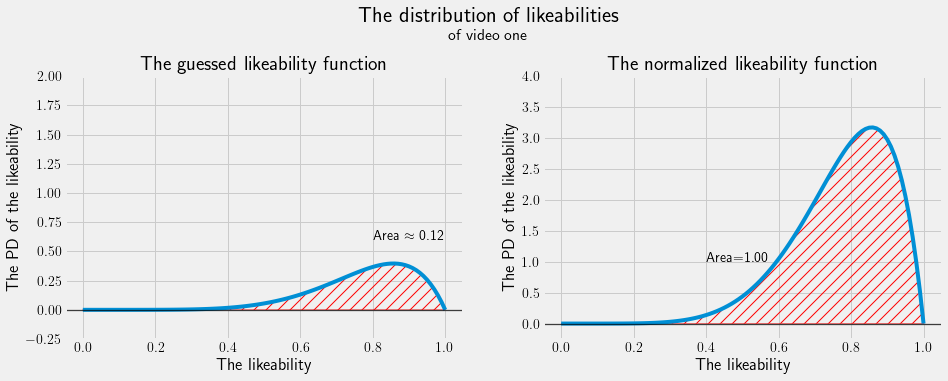

In [55]:
import scipy.special as sp

"""
Graphics for the statistical example
"""

# allow LaTeX
plt.rcParams['text.usetex'] = True


@auto_save()
def uniform_pdfs():
    fig = plt.figure(figsize=(6, 6))
    ax = plt.gca()

    xs = np.arange(0, 1, 0.01)
    ys = [1 for x in xs]
    ax.plot(xs, ys)
    ax.set_title(r"The initial distribution of a video's likeability")
    ax.set_ylabel("The probability density")
    ax.set_xlabel("The possible values")
    ax.set_ylim(-0.25, 2)

    # area
    ax.fill_between(xs, 0, ys, color='none', hatch='//', edgecolor='r')
    A = integrate.quad(lambda x: 1, 0, 1)
    ax.text(0.7, 1.1, f'Area={A[0]:.2f}')

    ax.axhline(y=0, color='black', linewidth=1.3, alpha=0.7)
    return fig


@auto_save()
def bino_pdfs():
    fig = plt.figure(figsize=(6, 6))
    ax = plt.gca()

    n = 7
    likes = 6
    p = 0.5
    Bi = lambda x: sp.comb(n, round(x)) * (p ** round(x)) * ((1 - p) ** (n - round(x)))

    xs = list(filter(lambda x: x != likes, range(0, 12)))
    ys = [Bi(x) for x in xs]
    ax.bar(xs, ys, 0.5)
    ax.set_title(r"The binomial distribution")
    ax.set_ylabel("The probability")
    ax.set_xlabel("The number of likes")
    ax.set_ylim(-0.01, 0.3)

    ax.bar([likes], [Bi(likes)], 0.5, color='r')
    ax.text(likes - 0.25, Bi(likes) + 0.01, f'{Bi(likes):.2f}')

    # area
    # ax.fill_between(xs, 0, ys, color='none', hatch='//', edgecolor='r')
    # A = integrate.quad(lambda x: 1, 0, 1)
    # ax.text(7.5, 1.75, rf'Area $\approx$ {A[0]:.2f}')

    ax.axhline(y=0, color='black', linewidth=1.3, alpha=0.7)
    return fig


@auto_save()
def beta_pdfs():
    fig, axs = plt.subplots(1, 2, figsize=(14, 5))
    plt.subplots_adjust(wspace=0.2, hspace=0.2, top=0.80)
    figtext(0.5, 0.95, 'The distribution of likeabilities', fontsize=22,
            ha='center')
    figtext(0.5, 0.9, 'of video one', fontsize=16,
            ha='center')
    xs = np.arange(0, 1.01, 0.01)

    n = 7
    x = 6

    # graph the guessed beta function
    G = lambda theta: sp.comb(n, x) * theta ** x * (1 - theta) ** (n - x)
    ys = [G(x) for x in xs]
    ax = axs[0]
    ax.plot(xs, ys)
    ax.set_title(f"The guessed likeability function")
    ax.set_ylabel("The PD of the likeability")
    ax.set_xlabel("The likeability")
    ax.set_ylim(-0.25, 2)
    ax.set_xlim(-0.05, 1.05)

    ax.fill_between(xs, 0, ys, color='none', hatch='//', edgecolor='r')
    A = integrate.quad(G, 0, 1)
    ax.text(0.8, 0.6, rf'Area $\approx$ {A[0]:.2f}')
    ax.axhline(y=0, color='black', linewidth=1.3, alpha=0.7)

    # graph the beta function
    B = lambda theta: G(theta) / A[0]
    ys = [B(x) for x in xs]
    ax = axs[1]
    ax.plot(xs, ys)
    ax.set_title(f"The normalized likeability function")
    ax.set_ylabel("The PD of the likeability")
    ax.set_xlabel("The likeability")
    ax.set_ylim(-0.25, 4)
    ax.set_xlim(-0.05, 1.05)

    ax.fill_between(xs, 0, ys, color='none', hatch='//', edgecolor='r')
    A = integrate.quad(B, 0, 1)
    ax.text(0.4, 1, f'Area={A[0]:.2f}')
    ax.axhline(y=0, color='black', linewidth=1.3, alpha=0.7)


    return fig


# uniform_pdfs()
# bino_pdfs()
beta_pdfs()
None

FileNotFoundError: [Errno 2] No such file or directory: 'figures/sim_ratings.png'

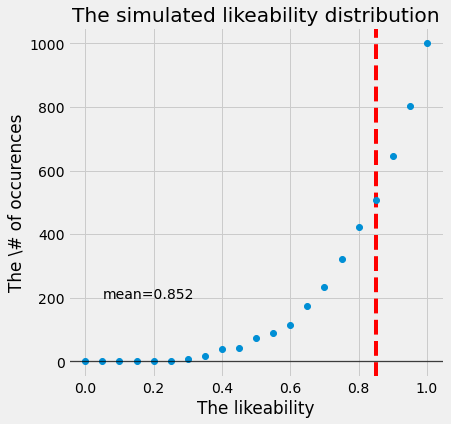

In [6]:
import random
#from numba import jit

"""
Graphics for the simulation example
"""


#@jit(nopython=True)
def simulate_goodness(goodness, sample_size, trials):
    samples = []
    for _ in range(sample_size):
        likes = 0
        for _ in range(trials):
            if random.random() <= goodness:
                likes += 1
        samples.append(likes)

    return samples


@auto_save()
def sim_ratings():
    fig = plt.figure(figsize=(6, 6))
    ax = plt.gca()

    likes = 4
    dislikes = 0
    samples = 1000

    xs = np.arange(0, 1.05, 0.05)
    ys = []

    for goodness in xs:
        sample_of_likes = simulate_goodness(goodness, samples, likes + dislikes)

        # how many samples match likes
        matched_count = len(list(filter(lambda l: l == likes, sample_of_likes)))
        ys.append(matched_count)

    # mean
    total = sum(ys)
    mean = sum([xs[i] * ys[i] / total for i in range(len(xs))])

    ax.axvline(x=mean, color='r', linestyle='--')
    ax.text(0.05, 200, f'mean={mean:.3f}')

    ax.plot(xs, ys, 'C0o')
    ax.set_title(f"The simulated likeability distribution")
    ax.set_ylabel("The \\# of occurences")
    ax.set_xlabel("The likeability")
    ax.set_xlim(-0.05, 1.05)
    ax.axhline(y=0, color='black', linewidth=1.3, alpha=0.7)

    return fig


sim_ratings()

None

In [19]:
"""
Graphics for the final triple comparisons

Examples,

Video 1:
https://www.youtube.com/watch?v=Nh_y1eGt9tY&list=PLOL6_MKUNdj6FpTN7uXP2QStapHtuA2iJ&index=25
5 likes, 0 dislikes

Goodness: 100%, but low certainty

Video 2:
https://www.youtube.com/watch?v=7ecjfjcjecI&list=PLOL6_MKUNdj6FpTN7uXP2QStapHtuA2iJ&index=73
455 likes, 30 dislikes

Goodness: 93.8%, but high certainty
"""


# the simulation, statistical, and bayesian perspective
def sim_stat_bayes_v1():
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))

    # have all three together for conclusion

    return fig

In [39]:
"""
The computations tab
"""


def sim_ratings(likes, dislikes, samples=100):
    xs = np.arange(0, 1, 0.01)
    ys = []

    for goodness in xs:
        sample_of_likes = simulate_goodness(goodness, samples, likes + dislikes)

        # how many samples match likes
        matched_count = len(list(filter(lambda l: l == likes, sample_of_likes)))
        ys.append(matched_count)

    # mean
    total = sum(ys)
    mean = sum([xs[i] * ys[i] / total for i in range(len(xs))])

    return mean


print(sim_ratings(4, 0))
print(sim_ratings(25, 0))
print(sim_ratings(34, 5))
print(sim_ratings(15, 0))
print(sim_ratings(200, 1))

None

0.827866531850354
0.958682634730539
0.8528033472803346
0.9366312056737588
0.9874999999999999


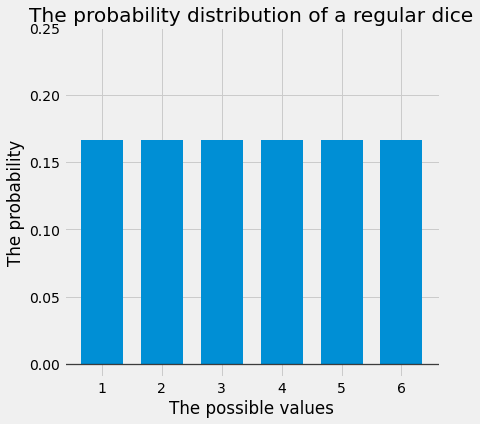

In [24]:
"""
Discrete Graphs
"""


@auto_save()
def discrete_uniform_pdfs():
    fig = plt.figure(figsize=(6, 6))
    ax = plt.gca()

    xs = np.arange(1, 7, 1)
    ys = [1 / 6 for x in xs]
    ax.bar(xs, ys, 0.7)
    ax.set_title(r"The probability distribution of a regular dice")
    ax.set_ylabel("The probability")
    ax.set_xlabel("The possible values")
    ax.set_ylim(-0.01, 0.25)

    ax.axhline(y=0, color='black', linewidth=1.3, alpha=0.7)

    return fig


discrete_uniform_pdfs()
None

e:\folder2021\pyprojects\mathsia\venv\lib\site-packages\ipykernel_launcher.py:40: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.


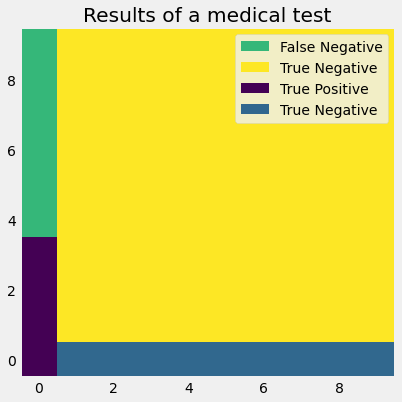

In [29]:
from matplotlib.patches import Patch

"""
Generate the medical scenario
"""

@auto_save()
def medical_scenario():
    fig = plt.figure(figsize=(6, 6))
    ax = plt.gca()

    n = 10
    sensitivity = 0.4
    specificity = 0.9
    have = 0.1

    xs = np.arange(0, n, 1)
    ys = np.arange(0, n, 1)


    color = [
        [0] * n for _ in range(n)
    ]

    for x in xs:
        for y in ys:
            if x < (n * have):
                if y < (n * sensitivity):
                    color[x][y] = 1
                else:
                    color[x][y] = 3
            else:
                if y < (n * (1-specificity)):
                    color[x][y] = 2
                else:
                    color[x][y] = 4



    ax.pcolormesh(xs, ys, np.array(color).transpose())

    custom = [
        Patch(facecolor='#35b779', label='False Negative'),
        Patch(facecolor='#fde725', label='True Negative'),
        Patch(facecolor='#440154', label='True Positive'),
        Patch(facecolor='#31678e', label='True Negative'),
    ]
    ax.legend(handles=custom, loc='upper right')
    ax.set_title("Results of a medical test")
    return fig

medical_scenario()
None


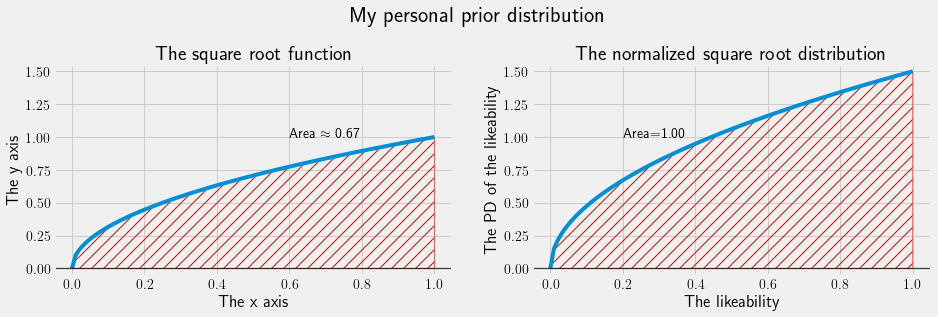

In [39]:
import math

"""
custom prior
"""

@auto_save()
def sqrt_per():
    # fig = plt.figure(figsize=(6, 6))
    # ax = plt.gca()
    #

    # xs = np.arange(0, 1.01, 0.01)
    # ys = [math.sqrt(x) for x in xs]
    #
    # ax.plot(xs, ys)
    # ax.set_title("The square root function")
    # ax.set_xlabel("The x axis")
    # ax.set_ylabel("The y axis")


    fig, axs = plt.subplots(1, 2, figsize=(14, 4))
    plt.subplots_adjust(wspace=0.2, hspace=0.2, top=0.80)
    xs = np.arange(0, 1.01, 0.01)
    figtext(0.5, 0.95, 'My personal prior distribution', fontsize=22,
            ha='center')

    ys = [math.sqrt(x) for x in xs]
    ax = axs[0]
    ax.plot(xs, ys)
    ax.set_title("The square root function")
    ax.set_xlabel("The x axis")
    ax.set_ylabel("The y axis")
    ax.set_ylim(-0.05, 1.55)

    ax.fill_between(xs, 0, ys, color='none', hatch='//', edgecolor='r')
    A = integrate.quad(math.sqrt, 0, 1)[0]
    ax.text(0.6, 1, rf'Area $\approx$ {A:.2f}')
    ax.axhline(y=0, color='black', linewidth=1.3, alpha=0.7)

    norm = lambda x: math.sqrt(x) / A
    ys = [norm(x) for x in xs]
    ax = axs[1]
    ax.plot(xs, ys)
    ax.set_title(f"The normalized square root distribution")
    ax.set_ylabel("The PD of the likeability")
    ax.set_xlabel("The likeability")
    ax.set_ylim(-0.05, 1.55)

    ax.fill_between(xs, 0, ys, color='none', hatch='//', edgecolor='r')
    ax.text(0.2, 1, f'Area=1.00')
    ax.axhline(y=0, color='black', linewidth=1.3, alpha=0.7)

    return fig


sqrt_per()
None

In [ ]:
import math


def likeability(rolls):
    n = len(rolls) + 1
    priors = [0] * n
    priors[0] = lambda theta: 3/2 * math.sqrt(theta)
    likelihoods = [0] * n
    evidences = [0] * n

    ys = [0] * n
    mean = integrate.quad(lambda t: t * priors[0](t), 0, 1)[0]
    ys[0] = mean

    index = 0
    while index < len(rolls):
        roll = rolls[index]
        is_like = roll == 'L'

        if is_like:
            likelihoods[index] =  lambda t1: t1
        else:
            likelihoods[index] = lambda t1: 1 - t1

        evidences[index] = integrate.quad(lambda t, i=index: likelihoods[i](t) * priors[i](t), 0, 1)[0]
        priors[index + 1] = lambda t, i=index: likelihoods[i](t) * priors[i](t) / evidences[i]

        mean = integrate.quad(lambda t, i=index: t * priors[i + 1](t), 0, 1)[0]
        ys[index+1] = mean
        index += 1

    return ys

def calc_like(likes, dislikes):
    rolls = "L" * likes + "D" * dislikes
    return likeability(rolls)[-1]

print(calc_like(705, 2))

@auto_save()
def nsqrt_incre():
    rolls1 = "DLLLLLL"
    rolls2 = "LLLLLLD"
    rolls3 = "LLLDLLL"

    fig = plt.figure(figsize=(12, 6))
    ax = plt.gca()

    xs = ["roll " + str(i+1) for i, r in enumerate(rolls1)]
    xs.insert(0, "base")
    ys1 = likeability(rolls1)
    ys2 = likeability(rolls2)
    ys3 = likeability(rolls3)

    ax.plot(xs, ys1, label=f"Order {rolls1}", alpha=0.6)
    ax.plot(xs, ys2, 'r',  label=f"Order {rolls2}", linestyle=':', alpha=0.6)
    ax.plot(xs, ys3, 'g',  label=f"Order {rolls3}", linestyle='--', alpha=1)
    ax.axhline(y=0, color='black', linewidth=1.3, alpha=0.7)
    ax.legend(loc=(0.8, 0.1))

    figtext(0.5, 0.9, 'The updating of likeability priors with nsqrt initial prior', fontsize=18, ha='center')
    figtext(0.5, 0.85, 'L = like, D = dislike', fontsize=14,
            ha='center')
    ax.set_title("")
    ax.set_xlabel("The mean of the likeability")
    ax.set_ylabel("The roll number")
    ax.set_ylim(-0.05, 1.05)

    return fig

nsqrt_incre()
None

In [43]:
vids = [
    (5, 1),
    (50, 10),
    (500, 100),
    (5000, 1000),
    (50000, 10000),
]

def naive(vids):
    for vid in vids:
        print(vid[0] / (vid[0] + vid[1]))

def stats(vids):
    for vid in vids:
        print((vid[0] + 1) / (vid[0] + vid[1] + 2))


def dif(vids):
    for vid in vids:
        n = vid[0] / (vid[0] + vid[1])
        s = (vid[0] + 1) / (vid[0] + vid[1] + 2)
        print(n-s)

# stats(vids)
# naive(vids)
dif(vids)

0.08333333333333337
0.010752688172043001
0.0011074197120709561
0.0001110740864156412
1.1110740753106363e-05
